In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as stats
import statsmodels.api as sm
import seaborn as sns
from collections import defaultdict
from itertools import combinations

In [2]:
currdf = pd.read_csv('cbb25.csv')
pastdf = pd.read_csv('pastCBB.csv')

pastdf['Win%'] = pastdf['W'] / pastdf['G'] #Win%
currdf['Win%'] = currdf['W'] / currdf['G'] #Win%

In [3]:
def pca(X, num_components):
    #PCA dimension reduction
    X_centered = X - X.mean(axis=0)
    cov_matrix = np.cov(X_centered, rowvar=False)
    eigenvalues, eigenvectors = np.linalg.eigh(cov_matrix)
    sorted_idx = np.argsort(eigenvalues)[::-1]
    top_eigenvectors = eigenvectors[:, sorted_idx[:num_components]]
    X_reduced = np.dot(X_centered, top_eigenvectors)
    return X_reduced, top_eigenvectors

def explained_variance(X):
    X_centered = X - X.mean(axis=0)
    cov_matrix = np.cov(X_centered, rowvar=False)
    eigenvalues, eigenvectors = np.linalg.eigh(cov_matrix)
    sorted_eigenvalues = np.sort(eigenvalues)[::-1]
    total_variance = np.sum(sorted_eigenvalues)
    explained_ratios = sorted_eigenvalues / total_variance
    return explained_ratios

def plot_scree(explained_ratios):
    cumulative_variance = np.cumsum(explained_ratios)
    
    plt.figure(figsize=(8,5))
    plt.plot(range(1, len(cumulative_variance)+1), cumulative_variance, marker='o')
    plt.title('Scree Plot (Elbow Method for PCA)')
    plt.xlabel('Number of Principal Components')
    plt.ylabel('Cumulative Variance Explained')
    plt.grid(True)
    plt.show()

In [4]:
def kmeans(X, k, max_iters=100):
    n_samples, n_features = X.shape
    np.random.seed(42)
    centers = X[np.random.choice(n_samples, k, replace=False)]

    for _ in range(max_iters):
        # Assign clusters
        distances = np.linalg.norm(X[:, np.newaxis] - centers, axis=2)
        clusters = np.argmin(distances, axis=1)

        # Update centers
        new_centers = np.array([X[clusters == i].mean(axis=0) for i in range(k)])

        # Convergence check
        if np.allclose(centers, new_centers):
            break
        centers = new_centers

    return clusters, centers


def kmeans_inertia(X, max_k=10):
    inertias = []
    
    for k in range(1, max_k + 1):
        centers, clusters = kmeans(X, k=k)
        # Compute inertia (sum of squared distances to nearest center)
        inertia = 0
        for i in range(len(X)):
            center = centers[clusters[i]]
            inertia += np.sum((X[i] - center) ** 2)
        inertias.append(inertia)
    
    return inertias

def plot_kmeans_elbow(inertias):
    plt.figure(figsize=(8,5))
    plt.plot(range(1, len(inertias) + 1), inertias, marker='o')
    plt.title('KMeans Elbow Plot (Choosing number of clusters)')
    plt.xlabel('Number of Clusters (k)')
    plt.ylabel('Inertia (Sum of Squared Distances)')
    plt.grid(True)
    plt.show()

In [5]:
def normalize(X):
    mean = X.mean(axis=0)
    std = X.std(axis=0)
    X_norm = (X - mean) / std
    return X_norm, mean, std

numeric_features = [
    'ADJOE','ADJDE','BARTHAG','EFG_O','EFG_D',
    'TOR','ORB','DRB','3P%','2P%','Win%','WAB','ADJ_T'
]
X_curr = currdf[numeric_features].values
X_past = pastdf[numeric_features].values
X_norm, mean, std = normalize(X_past)     
X_pca, components = pca(X_norm, num_components=6)

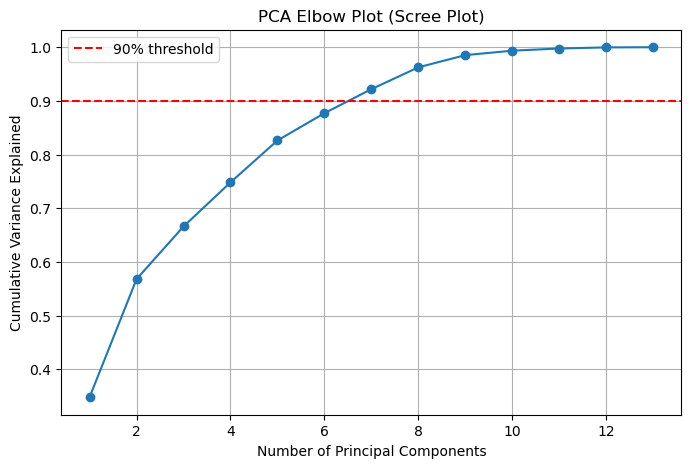

In [6]:
ratios = explained_variance(X_norm)

cumulative_variance = np.cumsum(ratios)

plt.figure(figsize=(8,5))
plt.plot(range(1, len(cumulative_variance)+1), cumulative_variance, marker='o')
plt.title('PCA Elbow Plot (Scree Plot)')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Variance Explained')
plt.axhline(y=0.9, color='r', linestyle='--', label='90% threshold')
plt.legend()
plt.grid(True)
plt.show()


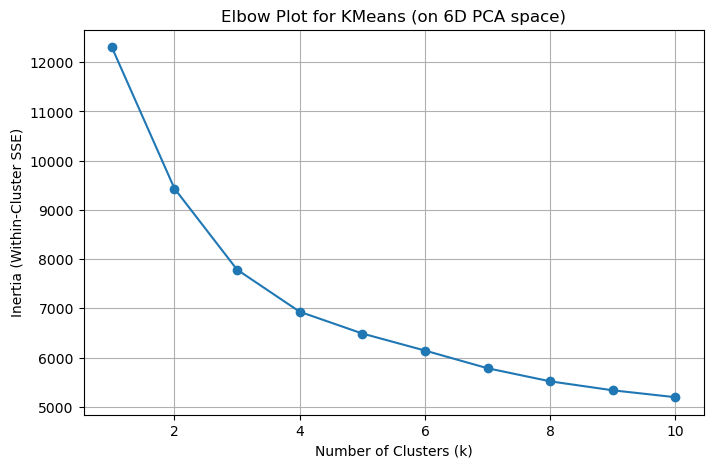

In [7]:
def compute_inertia(X, clusters, centers):
    # sum of squared distances of each point to its assigned cluster center
    inertia = 0
    for i, center in enumerate(centers):
        inertia += ((X[clusters == i] - center)**2).sum()
    return inertia

K = range(1, 11)
inertias = []

for k in K:
    clusters, centers = kmeans(X_pca, k=k)   # pca6_scores is (n,6) from before
    inertias.append(compute_inertia(X_pca, clusters, centers))

# Plot elbow curve
plt.figure(figsize=(8,5))
plt.plot(K, inertias, marker='o')
plt.title('Elbow Plot for KMeans (on 6D PCA space)')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia (Within-Cluster SSE)')
plt.grid(True)
plt.show()


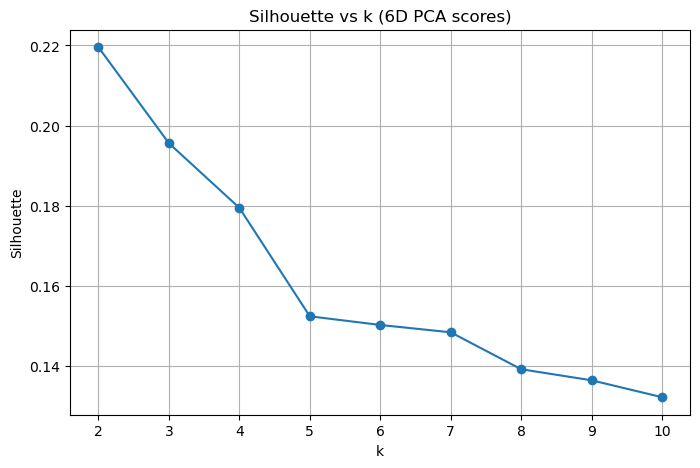

In [8]:
from sklearn.metrics import silhouette_score
sil_scores = []
for k in range(2, 11):
    cl, ctr = kmeans(X_pca, k=k)
    sil_scores.append(silhouette_score(X_pca, cl))
plt.figure(figsize=(8,5))
plt.plot(range(2,11), sil_scores, marker='o')
plt.title('Silhouette vs k (6D PCA scores)')
plt.xlabel('k'); plt.ylabel('Silhouette')
plt.grid(True); plt.show()


In [9]:
clusters, centers = kmeans(X_pca, k=8)
pastdf['Cluster'] = clusters

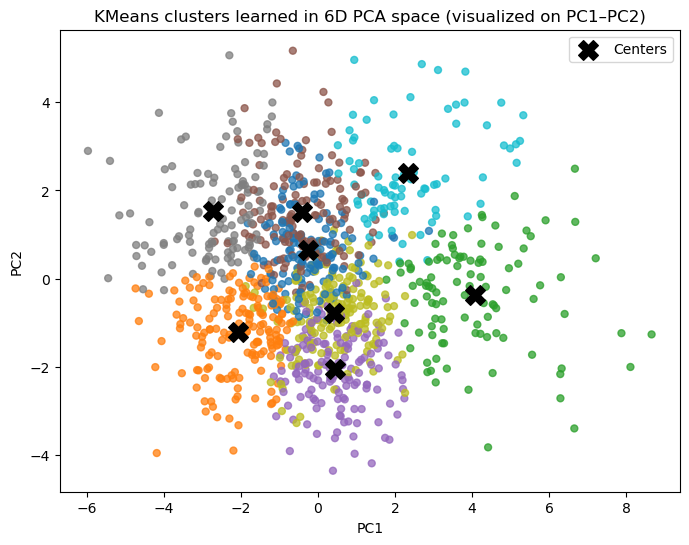

In [10]:
# 2D view of the 6D clusters
pc12 = X_pca[:, :2]         # (n_samples, 2)
centers12 = centers[:, :2]  # (k, 2)

plt.figure(figsize=(8,6))
plt.scatter(pc12[:,0], pc12[:,1], c=clusters, cmap='tab10', alpha=0.75, s=25)
plt.scatter(centers12[:,0], centers12[:,1], c='black', marker='X', s=200, label='Centers')
plt.xlabel('PC1'); plt.ylabel('PC2')
plt.title('KMeans clusters learned in 6D PCA space (visualized on PC1–PC2)')
plt.legend()
plt.show()


In [11]:
# Make sure these exist from your past fit:
# mean, std, components, centers, and numeric_features

# 1) Build feature matrix for the new teams using the SAME columns
X_new = currdf[numeric_features].values

# 2) Normalize with the past mean/std
X_new_norm = (X_new - mean) / std

# 3) Project into the SAME 6D PCA space
X_new_pca = X_new_norm @ components  # (n_new, 6)

# 4) Nearest-center assignment
def assign_to_centers(X, centers):
    # X: (n_samples, n_features), centers: (k, n_features)
    d = np.linalg.norm(X[:, None, :] - centers[None, :, :], axis=2)
    return d.argmin(axis=1)

curr_clusters = assign_to_centers(X_new_pca, centers)
currdf = currdf.copy()
currdf['Cluster'] = curr_clusters


In [12]:
pastdf.groupby("Cluster")['Result'].mean()

Cluster
0    46.601399
1    23.850299
2    61.923077
3    43.536913
4    51.885714
5    25.726496
6    47.136364
7    61.108434
Name: Result, dtype: float64

In [13]:
stage_counts = pastdf.groupby(['Cluster', 'Result']).size().unstack(fill_value=0)
print(stage_counts)

Result   1.0   2.0   4.0   8.0   16.0  32.0  64.0
Cluster                                          
0           0     0     2     6    11    47    77
1           9     7    12    27    43    44    25
2           0     0     0     1     0     5    98
3           1     1     7     5    13    50    72
4           0     2     1     3     8    30    96
5           6     4     9    18    32    24    24
6           0     2     1     4    20    50    99
7           0     0     0     0     1     6    76


In [14]:
currdf.head(64)

,Unnamed: 0,Team,Conf,G,W,ADJOE,ADJDE,BARTHAG,EFG_O,EFG_D,...,2P%,2P%D,3P%,3P%D,3PR,3PRD,ADJ_T,WAB,Win%,Cluster
0,0,Houston,B12,34,30,124.8900,88.0100,0.982310,52.7880,44.9400,...,47.8295,44.5500,39.4300,30.2140,34.7285,43.4313,61.8360,11.5200,0.882353,1
1,1,Duke,ACC,34,31,128.5200,91.3400,0.980820,57.4500,44.5300,...,57.9800,43.0300,38.6700,31.1370,44.6580,38.3157,66.0272,9.5500,0.911765,5
2,2,Auburn,SEC,33,28,129.1100,93.7120,0.975630,55.7250,46.0110,...,55.7330,46.8290,35.9660,29.8900,40.8136,35.3600,68.3133,12.7100,0.848485,5
3,3,Florida,SEC,34,30,127.7300,94.0130,0.971440,55.0370,45.3600,...,56.1290,46.3170,35.6730,29.4500,43.7720,37.2119,69.9590,11.2300,0.882353,5
4,4,Alabama,SEC,33,25,127.6400,96.4280,0.962050,56.3140,47.9500,...,59.7400,49.0950,35.3930,30.4190,46.6340,34.6420,75.1100,10.1400,0.757576,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59,59,Wofford,SC,34,19,111.5910,109.7248,0.546615,53.3730,51.8232,...,54.2600,52.0228,34.8120,34.5220,47.7230,46.0346,64.2335,-9.6193,0.558824,7
60,60,Robert_Morris,Horz,34,26,105.9185,105.0144,0.523715,51.3142,50.3145,...,50.7188,50.6159,34.6131,34.0187,36.7239,35.6720,68.2137,-4.0900,0.764706,7
61,61,Bryant,AE,34,23,105.7191,105.3152,0.511115,51.0162,47.7420,...,51.3161,47.3450,33.0213,32.5950,34.7285,36.1890,72.6700,-7.0140,0.676471,7
62,62,Norfolk_St_,MEAC,34,24,106.2178,109.0238,0.425219,52.4980,49.7119,...,54.5550,49.4110,30.8326,33.8175,27.6360,43.1308,66.5232,-5.3116,0.705882,7


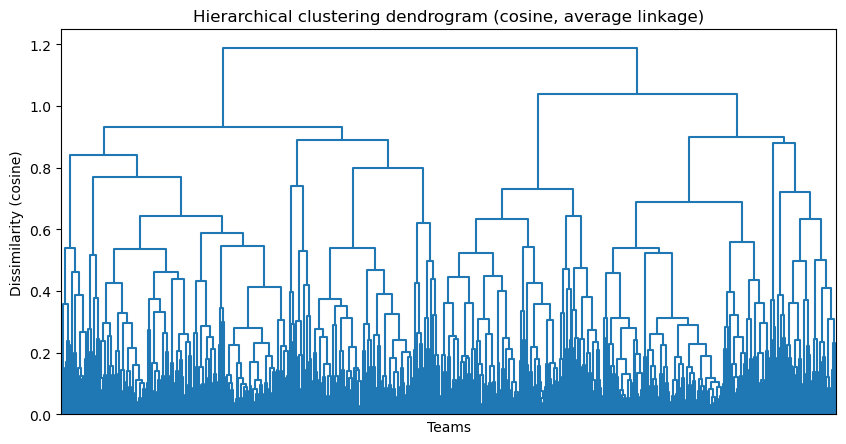

In [15]:
from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
import matplotlib.pyplot as plt

# 1) Pairwise cosine distances on the 6D PCA space (past only)
D = pdist(X_pca, metric='cosine')      # condensed distance vector

# 2) Linkage with 'average' (UPGMA) — works with cosine
Z = linkage(D, method='average')

# 3) (Optional) visualize dendrogram to eyeball structure
plt.figure(figsize=(10, 5))
dendrogram(Z, no_labels=True, color_threshold=0.0)
plt.title('Hierarchical clustering dendrogram (cosine, average linkage)')
plt.xlabel('Teams'); plt.ylabel('Dissimilarity (cosine)')
plt.show()

# 4) Choose your number of clusters, e.g., k=5 to mirror k-means
k_h = 5
past_labels_h = fcluster(Z, t=k_h, criterion='maxclust') - 1  # labels in 0..k-1

# Attach to pastdf
pastdf = pastdf.copy()
pastdf['HCluster'] = past_labels_h

In [18]:
print("pastdf rows:", len(pastdf))
print("currdf rows:", len(currdf))
print("X_pca shape:", X_pca.shape)       # should be (len(pastdf), 6)
print("X25_pca shape:", X_new_pca.shape)   # should be (len(currdf), 6)


pastdf rows: 1079
currdf rows: 68
X_pca shape: (1079, 6)
X25_pca shape: (68, 6)


In [20]:
def l2_normalize_rows(X, eps=1e-12):
    n = np.linalg.norm(X, axis=1, keepdims=True)
    n = np.where(n < eps, eps, n)
    return X / n

# 1) Compute centroids (in X_pca space) for each hierarchical cluster
k_h = pastdf['HCluster'].nunique()
centroids = np.vstack([
    X_pca[pastdf['HCluster'].values == c].mean(axis=0)
    for c in range(k_h)
])

# 2) L2-normalize both centroids and new points so cosine sim = dot product
C_hat   = l2_normalize_rows(centroids)
Xnewhat = l2_normalize_rows(X_new_pca)

# 3) Assign to the most similar centroid (max cosine similarity)
#    equivalently, min cosine distance.
cos_sim = Xnewhat @ C_hat.T             # (n_curr, k_h)
curr_h_labels = cos_sim.argmax(axis=1)  # 0..k_h-1

# Attach to current teams
currdf = currdf.copy()
currdf['HCluster'] = curr_h_labels


In [22]:
# Past clusters (hierarchical):
winners_per_hcluster = pastdf.loc[pastdf['Result']==1].groupby('HCluster').size()
print("Champions per HCluster:\n", winners_per_hcluster, "\n")

stage_counts_h = pastdf.groupby(['HCluster','Result']).size().unstack(fill_value=0)
print("Stage counts per HCluster:\n", stage_counts_h, "\n")

stage_props_h = (pastdf.groupby(['HCluster','Result']).size()
                 .groupby(level=0).apply(lambda s: s / s.sum())
                ).unstack(fill_value=0)
print("Stage proportions per HCluster:\n", stage_props_h, "\n")

avg_result_h = pastdf.groupby('HCluster')['Result'].mean()
print("Average result (lower is better) per HCluster:\n", avg_result_h)


Champions per HCluster:
 HCluster
0    15
2     1
dtype: int64 

Stage counts per HCluster:
 Result    1.0   2.0   4.0   8.0   16.0  32.0  64.0
HCluster                                          
0           15    13    21    45    69    88    66
1            0     0     6     9    26    59   112
2            1     3     4     5    25    66   121
3            0     0     0     1     3    21   208
4            0     0     1     4     5    22    60 

Stage proportions per HCluster:
 Result                 1.0       2.0       4.0       8.0       16.0      32.0  \
HCluster HCluster                                                               
0        0         0.047319  0.041009  0.066246  0.141956  0.217666  0.277603   
1        1         0.000000  0.000000  0.028302  0.042453  0.122642  0.278302   
2        2         0.004444  0.013333  0.017778  0.022222  0.111111  0.293333   
3        3         0.000000  0.000000  0.000000  0.004292  0.012876  0.090129   
4        4         0.000000  